In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.sparse import csr_matrix
from scipy.sparse import vstack as sparse_vstack
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product, compress
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/SARS2/"
PATH_DATA_GHDDI = "../datasets/SAR1/GHDDI"

In [88]:
def get_features_RDKIT_unfolded(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    bits = {}
    fps = {}
    fps_folded = {}
    mols = {}
    error_mols = 0
    mol_names = set()
    bits = {}
    for mol in structures_shared:
        if mol is None:
            error_mols += 1
            continue
        if mol.GetProp("_Name") in mol_names:
            continue
        name = int(mol.GetProp("_Name"))
        mol_names.add(name)
        AllChem.Compute2DCoords(mol)
        key = Chem.inchi.MolToInchiKey(mol)
        if (name, key) not in bits:
            # dictionary in the form bit: list of bonds
            bit_mol = {}
            fp = Chem.rdmolops.UnfoldedRDKFingerprintCountBased(mol,bitInfo=bit_mol)           
            fps[(name, key)] = fp.GetNonzeroElements()
            mols[(name, key)] = mol
            bits[(name, key)] = bit_mol
            fps_folded[(name, key)] = Chem.RDKFingerprint(mol)
            if str(name) in ['882', '11140', '3813', '6967', '10385', '11361', '3564', '10231', '14460', '10420', '11326', '5489', '5207', '6475']:
                max_val = -1
                for sublist in bit_mol[1781510256]:
                    max_val = max(max_val, max(sublist))
                if max_val >= mol.GetNumAtoms():
                    print(name, mol.GetNumAtoms(), max_val, key)
    print(f"Found problems in {error_mols} molecules")
    return fps, mols, bits, fps_folded
    # return fps, bits, mols, bits

def get_molecules_from_data(fps_folded, bits, fps, mols, data, id_column="Molecule_ID", structure_column="Standardized_Molecule_InChIKey", smiles_columns="Standardized_Molecule_Smiles", only_exact_matches=True, threshold_similarity=0.99):
    mol_ids = data[id_column]
    keys = data[structure_column]
    filtered_fps = []
    filtered_mols = []
    filtered_bits = []
    mask = []
    unfound_structures = Chem.SDWriter(os.path.join(PATH_DATA, "molecules_missing.sdf"))
    for id_val in zip(mol_ids, keys):
        if id_val in bits:
            mask.append(True)
            filtered_bits.append(bits[id_val])
            filtered_fps.append(fps[id_val])
            filtered_mols.append(mols[id_val])
        else:
            similar_mols = [k for k in bits if k[0] == id_val[0]]
            if not similar_mols:
                print("Could not find molecules with id", id_val[0])
                mask.append(False)
                continue
            if only_exact_matches:
                mask.append(False)
                print(id_val)
                print(similar_mols)
            else:
                fps_similars = [fps_folded[k] for k in similar_mols]
                smiles = data[(data[id_column] == id_val[0]) & (data[structure_column] == id_val[1])][smiles_columns].values[0]
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    if len(similar_mols) == 1:
                        mask.append(True)
                        filtered_bits.append(bits[similar_mols[0]])
                        filtered_fps.append(fps[similar_mols[0]])
                        filtered_mols.append(mols[similar_mols[0]])
                        continue
                    else:
                        mask.append(False)
                        print("Could not create molecule", id_val, "with smiles", smiles, "most similar", similar_mols)
                        continue
                mol.SetProp("_Name", str(id_val[0]))
                fp_mol = Chem.RDKFingerprint(mol)
                similarities = [DataStructs.TanimotoSimilarity(fp_mol, fp_possible) for fp_possible in fps_similars]
                # print(id_val)
                # print("Most similar molecules:")
                # for ids, sim in zip(similar_mols, similarities):
                    # print("\t", ids, sim)
                most_similar = np.argmax(similarities)
                if similarities[most_similar] > threshold_similarity:
                    # print("Selected: ", similar_mols[most_similar], similarities[most_similar])
                    mask.append(True)
                    filtered_bits.append(bits[similar_mols[most_similar]])
                    filtered_fps.append(fps[similar_mols[most_similar]])
                    filtered_mols.append(mols[similar_mols[most_similar]])
                else:
                    unfound_structures.write(mol)
                    print(id_val)
                    for ids, sim in zip(similar_mols, similarities):
                        print("\t", ids, sim)
                    mask.append(False)
    return filtered_bits, filtered_fps, filtered_mols, mask

def convert_IC50_to_um(data, col_values, col_units):
    new_vals = []
    for val, unit in zip(data[col_values], data[col_units]):
        if unit == "nM":
            new_vals.append(val/1000)
        elif unit == "µM":
            new_vals.append(val)
        else:
            raise ValueError(f"{unit} unit not found!")
    data[col_values] = new_vals
    data[col_units] = "µM"
    return data

def filter_duplicates(data, col_id, col_structure):
    dup = data.duplicated(subset=[col_id, col_structure], keep=False)
    to_remove = []
    for id_val in data[dup][col_id].unique():
        dup_data = data[data[col_id] == id_val]
        if len(set(dup_data["Is_active"])) != 1:
            to_remove.append(id_val)
    rm_masks = data[col_id].isin(to_remove)
    data = data[~rm_masks]
    return data, rm_masks

In [89]:
fps_SARS2, mols_SARS2, bits_SARS2, fps_folded_SARS2 = get_features_RDKIT_unfolded(os.path.join(PATH_DATA, "SIM_Broad_MProResults_ligprep_maestro.sd"))

10231 32 33 XIYOPDCBBDCGOE-UHFFFAOYSA-M
10385 17 17 NQFBZYYUAFJYNS-FPLPWBNLSA-N
10385 17 17 NQFBZYYUAFJYNS-FPLPWBNLSA-M
10420 27 27 MSHZHSPISPJWHW-UHFFFAOYSA-N
11140 17 17 WQYRHRAZNNRDIA-UHFFFAOYSA-N
11326 34 37 ZWVZORIKUNOTCS-UHFFFAOYSA-N


RDKit WARNING: [11:30:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [11:25:28] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: idx2
RDKit ERROR: Violation occurred on line 339 in file /opt/conda/conda-bld/rdkit_1591929907781/work/Code/GraphMol/ROMol.cpp
RDKit ERROR: Failed Expression: 54 < 54
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [11:30:36] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [11:30:36] ERROR: Could not sanitize molecule ending on line 15167
RDKit ERROR: [11:30:36] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [11:30:36] ERROR: Could not sanitize molecule ending on line 15269
RDKit ERROR: [11:30:36] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [11:30:36] ERROR: Could not sanitize 

11361 49 50 APSUXPSYBJVPPS-UHFFFAOYSA-P
11361 49 50 APSUXPSYBJVPPS-UHFFFAOYSA-O


RDKit WARNING: [11:30:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [11:30:36] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] ERROR: Could not sanitize molecule ending on line 22842
RDKit ERROR: [11:30:36] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] ERROR: Could not sanitize molecule ending on line 23015
RDKit WARNING: [11:30:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [11:30:36] ERROR: Explicit vale

882 54 56 OBMJQRLIQQTJLR-JRZNSJKLSA-O
3564 49 50 RICZEKWVNZFTNZ-UHFFFAOYSA-N
5489 12 12 JODIPZDLNMXGNX-UHFFFAOYSA-N
6475 19 19 BMKDZUISNHGIBY-UHFFFAOYSA-O
3813 32 34 QRXMDRCGEMIHER-UHFFFAOYSA-O
3813 32 34 QRXMDRCGEMIHER-UHFFFAOYSA-N
3813 32 34 ALKJNCZNEOTEMP-UHFFFAOYSA-O
5207 19 19 BMKDZUISNHGIBY-UHFFFAOYSA-O


RDKit WARNING: [11:30:37] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:37] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:37] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:37] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:37] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [11:30:37] Warning: molecule is tagged as 3D, but all Z coords are zero


6967 52 52 PKCCKSDNAOBTCF-QGCBMQFQSA-N
14460 57 61 GBABOYUKABKIAF-UHFFFAOYSA-P
14460 57 61 GBABOYUKABKIAF-UHFFFAOYSA-O
Found problems in 8 molecules


In [62]:
id_test = (9926, 'RFWGABANNQMHMZ-DXNYSGJVSA-N')
a = fps_SARS2[id_test]
#a.GetLength(), len(a.GetNonzeroElements())

In [63]:
threshold_activity = 20 # uM
data_orig_broad = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-broad.csv"), decimal=",")

In [64]:
data_orig_dompe = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-dompe.csv"), decimal=",")
data_orig_broad = data_orig_broad.rename(columns={"NAME": "Name",
                                                  "3CL-Pro IC50-15min (µM) (triplicates)": "IC50 µM 15 min",
                                                  "3CLpro\n IC50 slope (µM) (triplicates)": "IC50 µM slope"})
data_orig_dompe = data_orig_dompe.rename(columns={"IC50 µM\n 15 min\n (red manually confirmed)": "IC50 µM 15 min",
                                                  "IC50 µM\n slope\n (red manually confirmed)": "IC50 µM slope"})
data_SARS2 = pd.concat([data_orig_broad, data_orig_dompe])

correspondance_broad = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_broad.csv"), decimal=",")
correspondance_broad = correspondance_broad.rename(columns={"Molecule_id": "Molecule_ID"})
correspondance_dompe = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_dompe.csv"), decimal=",")
correspondance = pd.concat([correspondance_broad, correspondance_dompe])
correspondance = correspondance.rename(columns={"Fraunofer Compound Id": "Compound Id"})
data_SARS2 = data_SARS2.merge(correspondance, how="inner", on="Compound Id")

In [65]:
data_SARS2["Is_active"] = (data_SARS2["IC50 µM 15 min"] < threshold_activity).values.astype(int)
print(data_SARS2.shape)

(191, 32)


In [66]:
dup = data_SARS2.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
all_dup = data_SARS2.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep=False)
data_SARS2 = data_SARS2[~dup]
print(data_SARS2.shape)

Found 10 duplicated entries
(181, 32)


In [67]:
data_SARS2[all_dup]

/home/jfrancesc/miniconda3/envs/drug_learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Compound Id,Name,DTT sensitivity (if > 30 % loss of activity at 20 µM),Inhibition [%] Primary Screen (single point; 20 µM),"HC\nInhibition [%] (triplicate, 20 µM)","HC\n AV Inhibition [%] (triplicate, 20 µM)\nslope",AV inhibition +DTT 15min \nduplicates,IC50 µM 15 min,IC50 µM slope,%inhibition_d03-KU_LW,...,AV Inhibiton\n 15min,%Inhibition\n_slope PS,%Inhibition\n_15min PS,VeroE6% \nConfluence_d03,VeroE6 % \nInhibition_d03,Chemically reactive?,Molecule_ID,Standardized_Molecule_InChIKey,Standardized_Molecule_Smiles,Is_active
8,SPE_K81330143,Tideglusib,sensitiv,90.94,99.30,99.28,-4.89,0.15,0.14,-3.46,...,NaN,NaN,NaN,NaN,NaN,NaN,3878,PMJIHLSCWIDGMD-UHFFFAOYSA-N,O=C1SN(C(=O)N1Cc2ccccc2)c3cccc4ccccc34,1
9,SPE_K34149328,bonaphthone,sensitiv,95.47,99.37,100.31,37.44,0.16,0.38,-1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,4448,MXWZRRPNVLCHMY-UHFFFAOYSA-N,Brc1ccc2C(=O)C(=O)C=Cc2c1,1
30,SPE_K86972824,OLTIPRAZ,sensitiv,93.83,97.56,101.75,1.56,0.62,1.44,6.11,...,NaN,NaN,NaN,NaN,NaN,NaN,8437,CKNAQFVBEHDJQV-UHFFFAOYSA-N,CC1=C(SSC1=S)c2cnccn2,1
33,SPE_K55591206,(-)-Epigallocatechin Gallate,sensitiv,95.26,98.89,97.04,-22.36,0.72,1.29,-1.41,...,NaN,NaN,NaN,NaN,NaN,NaN,522,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@H...,1
38,SPE_K68408467,PROFLAVINE HEMISULFATE,sensitiv,60.89,76.55,99.87,20.41,0.83,2.02,19.09,...,NaN,NaN,NaN,NaN,NaN,NaN,6835,WDVSHHCDHLJJJR-UHFFFAOYSA-N,Nc1ccc2cc3ccc(N)cc3nc2c1,1
58,SPE_M87138257,Acriflavine hydrochloride,Acriflavine hydrochloride,59.00,67.97,99.10,68.22,1.93,5.10,-26.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
74,SPE_K20313525,rosmarinic-acid,sensitiv,95.67,94.92,94.14,-17.76,3.86,4.96,8.26,...,NaN,NaN,NaN,NaN,NaN,NaN,8605,DOUMFZQKYFQNTF-WUTVXBCWSA-N,OC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)\C=C\c2ccc(...,1
95,SPE_A49172652,LANSOPRAZOLE,sensitiv,97.15,98.57,96.07,-12.10,7.25,10.83,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,348,MJIHNNLFOKEZEW-UHFFFAOYSA-N,Cc1c(OCC(F)(F)F)ccnc1CS(=O)c2nc3ccccc3[nH]2,1
112,SPE_K76841105,Tazarotene (Avage),Tazarotene (Avage),-880.10,-692.49,108.07,-663.39,13.50,321.75,-2.40,...,NaN,NaN,NaN,NaN,NaN,NaN,445,OGQICQVSFDPSEI-UHFFFAOYSA-N,CCOC(=O)c1ccc(nc1)C#Cc2ccc3SCCC(C)(C)c3c2,1
137,SPE_K33623053,Rose Bengal Sodium Salt,Rose Bengal Sodium Salt,99.60,74.85,-2.27,69.98,1176.55,26.97,22.43,...,NaN,NaN,NaN,NaN,NaN,NaN,5272,IICCLYANAQEHCI-UHFFFAOYSA-N,Oc1c(I)cc2c(Oc3c(I)c(O)c(I)cc3C24OC(=O)c5c(Cl)...,0


In [68]:
bits_SARS2, features_SARS2, mols_SARS2, mask = get_molecules_from_data(fps_folded_SARS2, bits_SARS2, fps_SARS2, mols_SARS2, data_SARS2, only_exact_matches=False, threshold_similarity=0.2)
data_filtered = data_SARS2[mask]
active_SARS2 = data_filtered["Is_active"].values
print(sum(mask))

RDKit ERROR: [11:25:13] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [11:25:15] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:25:15] Explicit valence for atom # 1 N, 4, is greater than permitted


Could not find molecules with id 11947
Could not find molecules with id 12210
Could not find molecules with id 10107
Could not find molecules with id 7168
(6835, 'WDVSHHCDHLJJJR-UHFFFAOYSA-N')
	 (6835, 'IHRJICSCSWHANS-UHFFFAOYSA-N') 0.14022988505747128
Could not find molecules with id 11215
Could not find molecules with id 10484
Could not find molecules with id 10913
Could not find molecules with id 12105
Could not find molecules with id 11495
Could not find molecules with id 6326
Could not find molecules with id 10781
Could not find molecules with id 11917
Could not find molecules with id 10766
Could not find molecules with id 12364
(10817, 'PSFDQSOCUJVVGF-UHFFFAOYSA-N')
	 (10817, 'FLJHILGVZZUAHY-UHFFFAOYSA-N') 0.1834862385321101
165


RDKit ERROR: [11:25:15] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [11:25:15] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [11:25:15] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [11:25:15] Explicit valence for atom # 3 N, 4, is greater than permitted


In [69]:
len(bits_SARS2), len(features_SARS2), len(mols_SARS2)

(165, 165, 165)

Load GHDDI data set

In [70]:
data_GHDDI_orig = pd.read_csv(os.path.join(PATH_DATA_GHDDI, "3CLProtease_ActiveDataset.csv"), decimal=",")
activity_col = "value_GHDDI"
measures_col = "parameter_GHDDI"
units_col = "unit_GHDDI"
id_col = "Molecule_ID"

In [71]:
data_GHDDI = data_GHDDI_orig.dropna(subset=[activity_col, id_col]).copy()
data_GHDDI[id_col] = data_GHDDI[id_col].astype(int)
data_GHDDI = data_GHDDI[data_GHDDI[measures_col] == "IC50"]
dup = data_GHDDI.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
data_GHDDI = data_GHDDI[~dup]
data_GHDDI.shape

Found 0 duplicated entries


(401, 33)

Convert all experimental values to micromolar

In [72]:
data_GHDDI = convert_IC50_to_um(data_GHDDI, activity_col, units_col)
data_GHDDI["Is_active"] = (data_GHDDI[activity_col] < threshold_activity).values.astype(int)

In [73]:
fps_rdkit_GHDDI, mols_rdkit_GHDDI, bits_rdkit_GHDDI, fps_folded_GHDDI = get_features_RDKIT_unfolded(os.path.join(PATH_DATA_GHDDI, "3C-like_protease_GHDDI_ligprep_maestro.sdf"))

RDKit WARNING: [11:25:18] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [11:25:19] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:25:19] ERROR: Could not sanitize molecule ending on line 11557
RDKit WARNING: [11:25:19] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [11:25:19] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:25:20] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [11:25:20] ERROR: Could not sanitize molecule ending on line 85833
RDKit ERROR: [11:25:20] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [11:25:20] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [11:25:20] ERROR: Could not sanitize molecule ending on line 86055
RDKit ERROR: [11:25:20] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [11:25:20] Explicit valence for atom

Found problems in 8 molecules


In [74]:
bits_GHDDI, features_GHDDI, mols_GHDDI, mask_GHDDI = get_molecules_from_data(fps_folded_GHDDI, bits_rdkit_GHDDI, fps_rdkit_GHDDI, mols_rdkit_GHDDI, data_GHDDI, only_exact_matches=False, threshold_similarity=0.2)
data_GHDDI = data_GHDDI[mask_GHDDI]
active_SARS1 = data_GHDDI["Is_active"].values
print(data_GHDDI.shape, sum(mask_GHDDI))

Could not find molecules with id 9602


RDKit ERROR: [11:25:20] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:25:22] Explicit valence for atom # 16 N, 4, is greater than permitted


(400, 34) 400


RDKit ERROR: [11:25:22] Explicit valence for atom # 9 N, 4, is greater than permitted


In [75]:
sources = ["SARS2" for _ in bits_SARS2]+["SARS1" for _ in bits_GHDDI]
joined_sets = pd.concat([data_filtered, data_GHDDI], ignore_index=True)

data = []
row = []
col = []
for i, fp in enumerate(features_SARS2+features_GHDDI):
    for val in fp:
        data.append(fp[val])
        row.append(i)
        col.append(val)

renamed_features = {}
index = 0
# rename features to reduce columns in the sparse matrix
for i, ind in enumerate(col):
    if ind in renamed_features:
        col[i] = renamed_features[ind]
    else:
        renamed_features[ind] = index
        col[i] = index
        index += 1
rename_lookup = {renamed_features[k]: k for k in renamed_features}
joined_features = csr_matrix((data, (row, col)), shape=(max(row)+1, max(col)+1), dtype=np.int16)

joined_bits = bits_SARS2+bits_GHDDI
joined_mols = mols_SARS2+mols_GHDDI
joined_sets, mask_to_rm = filter_duplicates(joined_sets, id_col, "Standardized_Molecule_InChIKey")
joined_features = joined_features[~mask_to_rm]
joined_bits = list(compress(joined_bits, ~mask_to_rm))
joined_mols = list(compress(joined_mols, ~mask_to_rm))
joined_sources = list(compress(sources, ~mask_to_rm))
active = joined_sets["Is_active"].values
print(joined_sets.shape, len(joined_bits), len(joined_mols), joined_features.shape, joined_features.dtype)

(563, 62) 563 563 (563, 52839) int16


Actives 310, 55.06%; Inactives 253, 44.94%


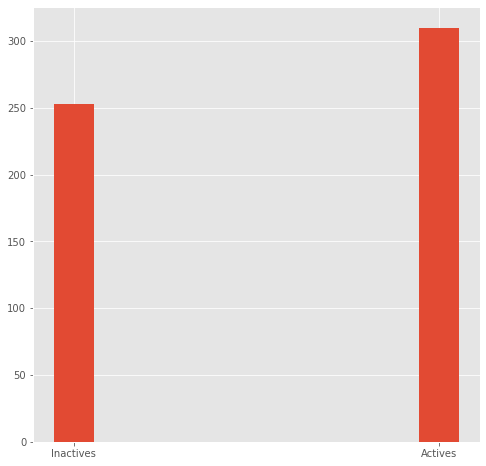

In [76]:
plt.figure(figsize=(8,8))
plt.hist(active, bins=10);
plt.xticks([0.05, 0.95], ["Inactives", "Actives"])
n_active = sum(active)
n_inactive = len(active)-n_active
print(f"Actives {n_active}, {100*n_active/(n_active+n_inactive):.2f}%; Inactives {n_inactive}, {100*n_inactive/(n_active+n_inactive):.2f}%")

In [77]:
def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    f, ax = plt.subplots(1, 1)
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()
    
def grid_search_SVM(train_data, test_data, train_labels, test_labels, max_gamma=1, min_gamma=0.001, max_C=100, min_C=0.01, n_points=30):
    accuracy = []
    MCCs = []
    C_values = np.geomspace(min_C, max_C, num=n_points)
    gamma_values = np.geomspace(min_gamma, max_gamma, num=n_points)
    for c_val in C_values:
        acc = []
        mcc = []
        for gamma in gamma_values:
            svm = SVC(C=c_val, kernel="rbf", gamma=gamma)
            svm.fit(train_data, train_labels)
            predictions = svm.predict(test_data)
            print(f"C={c_val}, gamma={gamma}")
            vals = print_metrics(predictions, test_labels)
            acc.append(vals[0])
            mcc.append(vals[1])
        accuracy.append(acc)
        MCCs.append(mcc)

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(MCCs, annot=False, ax = ax, cmap="Greens")
    ax.set_yticklabels(np.round(C_values, 2), rotation=0)
    ax.set_xticklabels(np.round(gamma_values, 2), rotation=90)
    ax.set_ylabel("C value")
    ax.set_xlabel(r"$\gamma$")
    plt.show()

In [80]:
train_data, test_data, train_labels, test_labels = train_test_split(joined_features, active, test_size=0.25, random_state=42, stratify=active)

NER: 0.763, Sensitivity or recall: 0.795, Specificity: 0.730, Precision: 0.785, Correctly classified: 0.766, MCC: 0.526


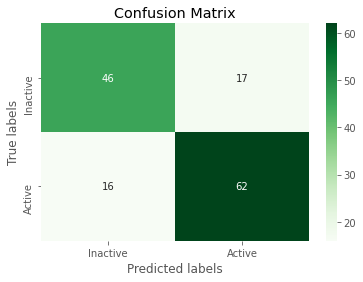

In [81]:
clf = DecisionTreeClassifier(random_state=42, class_weight="balanced")
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

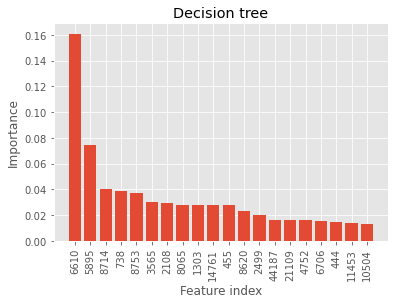

In [82]:
order_dt = np.argsort(clf.feature_importances_)[::-1]
x = np.array(range(len(clf.feature_importances_)))[:20]
plt.bar(x, clf.feature_importances_[order_dt][:20])
plt.xticks(x, order_dt[:20], rotation=90);
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Decision tree");

NER: 0.761, Sensitivity or recall: 0.872, Specificity: 0.651, Precision: 0.756, Correctly classified: 0.773, MCC: 0.541


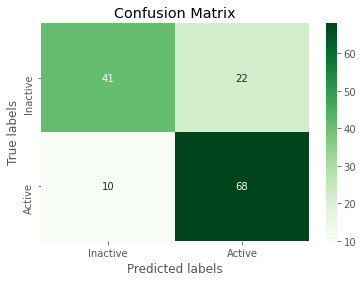

In [83]:
clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

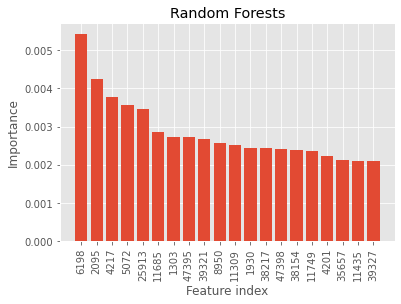

In [84]:
order_RF = np.argsort(clf.feature_importances_)[::-1]
x = np.array(range(len(clf.feature_importances_)))[:20]
plt.bar(x, clf.feature_importances_[order_RF][:20])
plt.xticks(x, order_RF[:20], rotation=90);
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Random Forests");

In [85]:
best = list(set(order_dt[:20]) & set(order_RF[:20]))
print(order_dt[:20])
print(order_RF[:20])
print(best)
print([rename_lookup[x] for x in best])

[ 6610  5895  8714   738  8753  3565  2108  8065  1303 14761   455  8620
  2499 44187 21109  4752  6706   444 11453 10504]
[ 6198  2095  4217  5072 25913 11685  1303 47395 39321  8950 11309  1930
 38217 47398 38154 11749  4201 35657 11435 39327]
[1303]
[1781510256]


In [90]:
def separate_molecules_fp_bit(bit, all_bits):
    positive_ind = []
    negative_ind = []
    for i, val in enumerate(all_bits):
        if bit in val:
            positive_ind.append(i)
        else:
            negative_ind.append(i)
    return positive_ind, negative_ind

def generate_bit_plots(feature, all_bits, all_mols, all_sources, renaming_dict, folder="feature_structures_unfolded", multiple=True):
    old_feature = renaming_dict[feature]
    os.makedirs(folder, exist_ok=True)
    pos, neg = separate_molecules_fp_bit(old_feature, all_bits)
    mols_pos = [all_mols[x] for x in pos]
    names_pos = [all_mols[ind].GetProp("_Name")+"-"+all_sources[ind] for ind in pos]
    # highlight_bonds = [all_bits[ind][old_feature] for ind in pos]
    highlight_atoms = []
    for ind in pos:
        atoms = set()
        for l in all_bits[ind][old_feature]:
            atoms |= set(l)
        highlight_atoms.append(list(atoms))
    # add hydrogens to obtain accurate atom acount and avoid issues when drawing structures
    mols_with_hydrogens = []
    for mol in mols_pos:
        mol_h = Chem.AddHs(mol)
        AllChem.Compute2DCoords(mol_h)
        mols_with_hydrogens.append(mol_h)
    img = Draw.MolsToGridImage(mols_with_hydrogens, molsPerRow=3, subImgSize=(400,400), legends=names_pos, maxMols=1e4, useSVG=True, highlightAtomLists=highlight_atoms)
    with open(os.path.join(folder, f'bit_{feature+1}.svg'), 'w') as f:
        f.write(img.data)

In [91]:
for index in best:
    generate_bit_plots(index, joined_bits, joined_mols, joined_sources, rename_lookup)

Text(0, 0.5, 'Importance')

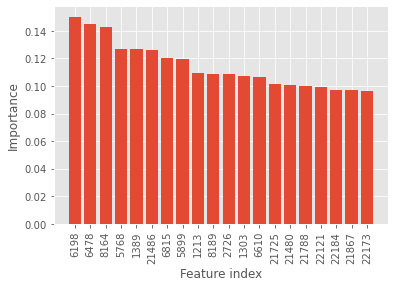

In [99]:
sel = SelectKBest(mutual_info_classif, k=10)
features = sel.fit_transform(joined_features, active)
order_chi2 = np.argsort(sel.scores_)[::-1]
x = np.array(range(len(sel.scores_)))[:20]
plt.bar(x, sel.scores_[order_chi2][:20])
plt.xticks(x, order_chi2[:20], rotation=90);
plt.xlabel("Feature index")
plt.ylabel("Importance")

In [100]:
for index in order_chi2[:10]:
    generate_bit_plots(index, joined_bits, joined_mols, joined_sources, rename_lookup)

We test a similar approach with the SARS2 data set only

In [93]:
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(features_SARS2, active_SARS2, test_size=0.25, random_state=42, stratify=active_SARS2)

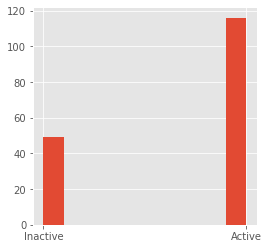

In [94]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS2, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

In [95]:
C= 7.8804628
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(train_data2, train_labels2)
predictions = svm.predict(test_data2)
vals = print_metrics(predictions, test_labels2)
plot_confusion(predictions, test_labels2)

TypeError: float() argument must be a string or a number, not 'dict'

Try with the SARS1 data set only

In [ ]:
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(features_GHDDI, active_SARS1, test_size=0.25, random_state=42, stratify=active_SARS1)

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS1, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

In [ ]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(train_data1, train_labels1)
predictions = svm.predict(test_data1)
vals = print_metrics(predictions, test_labels1)
plot_confusion(predictions, test_labels1)

Train with SARS1, test with SARS2 

In [ ]:
C= 8.53
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_GHDDI, active_SARS1)
predictions = svm.predict(features_SARS2)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

Similar but adding class weights

In [ ]:
C= 8.53
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_GHDDI, active_SARS1)
predictions = svm.predict(features_SARS2)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

Train with SARS2, test with SARS1

In [ ]:
C= 1.172102
gamm = 0.0239
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(features_SARS2, active_SARS2)
predictions = svm.predict(features_GHDDI)
vals = print_metrics(predictions, active_SARS1)
plot_confusion(predictions, active_SARS1)

In [ ]:
C= 1.172102
gamm = 0.0239
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_SARS2, active_SARS2)
predictions = svm.predict(features_GHDDI)
vals = print_metrics(predictions, active_SARS1)
plot_confusion(predictions, active_SARS1)

Try 10-fold cross validation with the full data set 

In [118]:
def run_cross_validation(features, labels, folds=5, iters=10, clf=RandomForestClassifier(random_state=42, class_weight="balanced"), verbose=True):
    MCCs_val = []
    MCCs_test = []
    accs_val = []
    accs_test = []
    for i in range(iters):
        training_set, testing_set, training_labels, testing_labels = train_test_split(features, labels, test_size=0.25, random_state=i, stratify=labels)
        skf = StratifiedKFold(n_splits=folds)
        for i, (train_index, test_index) in enumerate(skf.split(training_set, training_labels)):
            train_data, val_data = training_set[train_index], training_set[test_index]
            train_labels, val_labels = training_labels[train_index], training_labels[test_index]
            if verbose:
                print(f"Calculating with fold {i}")
            clf.fit(train_data, train_labels)
            predictions = clf.predict(val_data)
            val_acc, val_mcc = print_metrics(predictions, val_labels, verbose=verbose)
            if verbose:
                plot_confusion(predictions, test_labels)
            MCCs_val.append(val_mcc)
            accs_val.append(val_acc)
        clf.fit(training_set, training_labels)
        predictions = clf.predict(testing_set)
        test_acc, test_mcc = print_metrics(predictions, testing_labels, verbose=verbose)
        accs_test.append(test_acc)
        MCCs_test.append(test_mcc)
    return MCCs_val, MCCs_test, accs_val, accs_test

def plot_results_CV(MCCs_val, MCCs_test, accs_val, accs_test, y_lims=None):
    MCCs_val = np.array(MCCs_val)
    MCCs_val[np.isnan(MCCs_val)] = 0
    MCCs_test = np.array(MCCs_test)
    MCCs_test[np.isnan(MCCs_test)] = 0
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].boxplot([np.array(accs_val)[~np.isnan(accs_val)], np.array(accs_test)[~np.isnan(accs_test)]], labels=["Validation", "Testing"])
    ax[1].boxplot([MCCs_val, MCCs_test], labels=["Validation", "Testing"])
    if y_lims is not None:
        ax[0].set_ylim(top=y_lims[1], bottom=y_lims[0])
        ax[1].set_ylim(top=y_lims[1], bottom=y_lims[0])
    else:
        y_min = -0.1+np.nanmin([np.nanmin(accs_val), np.nanmin(accs_test), np.nanmin(MCCs_val), np.nanmin(MCCs_test)])
        y_max = 0.1+np.nanmax([np.nanmax(accs_val), np.nanmax(accs_test), np.nanmax(MCCs_val), np.nanmax(MCCs_test)])
        ax[0].set_ylim(top=y_max, bottom=y_min)
        ax[1].set_ylim(top=y_max, bottom=y_min)
    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("MCC")

In [ ]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm = run_cross_validation(joined_features, active, folds=10, verbose=False, clf=svm)

In [ ]:
plot_results_CV(MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm, y_lims=(0, 1))

In [119]:
model = DecisionTreeClassifier(random_state=42)
MCC_val_tree, MCC_test_tree, acc_val_tree, acc_test_tree = run_cross_validation(joined_features, active, folds=10, verbose=False, clf=model)

/home/jfrancesc/miniconda3/envs/drug_learning/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/jfrancesc/miniconda3/envs/drug_learning/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


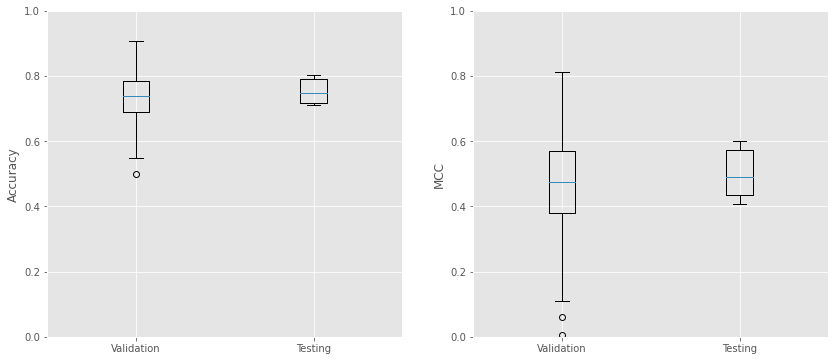

In [120]:
plot_results_CV(MCC_val_tree, MCC_test_tree, acc_val_tree, acc_test_tree, y_lims=(0, 1))

In [121]:
MCC_train_RF, MCC_test_RF, acc_train_RF, acc_test_RF = run_cross_validation(joined_features, active, folds=10, verbose=False)

/home/jfrancesc/miniconda3/envs/drug_learning/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/jfrancesc/miniconda3/envs/drug_learning/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


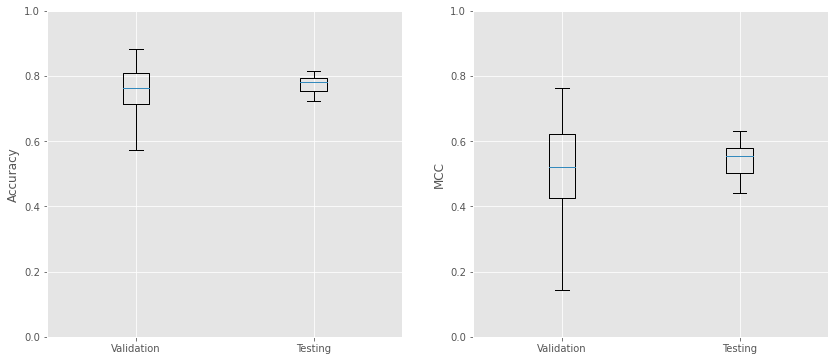

In [122]:
plot_results_CV(MCC_train_RF, MCC_test_RF, acc_train_RF, acc_test_RF, y_lims=(0, 1))

In [ ]:
percentiles = list(range(1,101,5))
n_features = []
MCCs = []
accs = []
skf = StratifiedKFold(n_splits=10)
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    transform_features = feat_select.fit_transform(joined_features, active)
    n_features.append(transform_features.shape[1])
    mcc_CV = []
    acc_CV = []
    for i, (train_index, test_index) in enumerate(skf.split(transform_features, active)):
        train_data, test_data = transform_features[train_index], transform_features[test_index]
        train_labels, test_labels = active[train_index], active[test_index]
        print(f"Calculating with fold {i}, percentile {percentile}")
        clf = RandomForestClassifier(random_state=42)
        clf.fit(train_data, train_labels)
        predictions = clf.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        mcc_CV.append(test_mcc)
        acc_CV.append(test_acc)
    MCCs.append(mcc_CV)
    accs.append(acc_CV)

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(MCCs, labels=n_features)
plt.ylabel("MCC")
plt.xlabel("Features");

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(accs, labels=n_features)
plt.ylabel("Accuracy")
plt.xlabel("Features");

We use now cross validation with the SARS2 set only and then use SARS1 as test set, with a Random Forest

In [ ]:
# features_full, features_GHDDI, active_SARS2, active_SARS1
MCC_val12, MCC_test12, acc_val12, acc_test12 = run_cross_validation(features_SARS2, active_SARS2, folds=5, verbose=False)

In [ ]:
plot_results_CV(MCC_val12, MCC_test12, acc_val12, acc_test12)

And use CV with SARS1 to test with SARS 2

In [ ]:
MCC_val12, MCC_test12, acc_val12, acc_test12 = run_cross_validation(features_GHDDI, active_SARS1, folds=10, verbose=False)

In [ ]:
plot_results_CV(MCC_val12, MCC_test12, acc_val12, acc_test12)

We now keep only the features selected from the combination of mutual information, chi-squared and the most important features from a decision tree and random forest

In [ ]:
best_features = joined_features[:, best]
best_features_SARS2 = features_SARS2[:, best]
best_features_SARS1 = features_GHDDI[:, best]
print(best_features.shape)

In [ ]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

In [ ]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [ ]:
model = RandomForestClassifier(random_state=42, n_estimators=1)
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

In [ ]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [ ]:
model = DecisionTreeClassifier(random_state=42)
MCC_val_all_tree, MCC_test_all_tree, acc_val_all_tree, acc_test_all_tree = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

In [ ]:
plot_results_CV(MCC_val_all_tree, MCC_test_all_tree, acc_val_all_tree, acc_test_all_tree)

Try with SVM

In [ ]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm = run_cross_validation(best_features, active, folds=10, verbose=False, clf=svm)

In [ ]:
plot_results_CV(MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm)

Use only SARS2 set

In [ ]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features_SARS2, active_SARS2, clf=model, folds=5, verbose=False)

In [ ]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

Use only SARS1 set

In [ ]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features_SARS1, active_SARS1, clf=model, folds=10, verbose=False)

In [ ]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [ ]:
n_features = []
MCCs = []
accs = []
skf = StratifiedKFold(n_splits=10)
for n in range(1, len(best)):
    feat_select = SelectKBest(chi2, k=n)
    transform_features = feat_select.fit_transform(best_features, active)
    n_features.append(transform_features.shape[1])
    mcc_CV = []
    acc_CV = []
    for i, (train_index, test_index) in enumerate(skf.split(transform_features, active)):
        train_data, test_data = transform_features[train_index], transform_features[test_index]
        train_labels, test_labels = active[train_index], active[test_index]
        print(f"Calculating with fold {i}, percentile {percentile}")
        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(train_data, train_labels)
        predictions = clf.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        mcc_CV.append(test_mcc)
        acc_CV.append(test_acc)
    MCCs.append(mcc_CV)
    accs.append(acc_CV)


In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(MCCs, labels=n_features)
plt.ylabel("MCC")
plt.xlabel("Features");

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(best_features, active, test_size=0.25, random_state=42, stratify=active)

In [ ]:
grid_search_SVM(train_data, test_data, train_labels, test_labels)

In [ ]:
C=3.039195382313198
gamma=0.005298316906283708
svm_obj = SVC(C=C, kernel="rbf", gamma=gamma, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features, active, folds=10, clf=svm_obj, verbose=False)

In [ ]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(joined_features, active, test_size=0.25, random_state=42, stratify=active)

In [ ]:
C= 0.788046
gamm = 0.0239502
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = GaussianNB()
eclf1 = VotingClassifier(estimators=[('svm', svm), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1.fit(train_data, train_labels)
predictions = eclf1.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

In [ ]:
MCC_val_vote, MCC_test_vote, acc_val_vote, acc_test_vote = run_cross_validation(best_features, active, folds=10, clf=eclf1, verbose=False)

In [ ]:
plot_results_CV(MCC_val_vote, MCC_test_vote, acc_val_vote, acc_test_vote)